In [17]:
# %%javascript
# function ClickConnect(){
# console.log("Working");
# document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(ClickConnect,60000)

# The shortcut for commenting multiple lines in colab is ctrl + /
""" Pattern Classification and Experiment Design Course Project"""
#%% Importing the required modules
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Mounting the google drive and reading the csv data file
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv')
# df = df.head(10000)
#%% a) Data Visualization
n = df.shape[0]                                   # Number of samples
n_f = df.shape[1] - 2                             # Number of features
n1 = sum(np.ones([n,1])[df["Label"]])[0]          # Number of samples in class 1
n2 = n - n1                                       # Number of samples in class 2
print(f"Number of samples in class 0: {n1}\n")
print(f"Number of samples in class 1: {n2}\n")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of samples in class 0: 23155.0

Number of samples in class 1: 86324.0



In [18]:
#b) Isolating the evaluation data, 0.25% of the data is kept for final 
# evaluation of the classifer"""
from sklearn.model_selection import train_test_split
X = df.drop(['Label', 'KIBA'], axis = 1)
y = df['Label']
X_t, X_eval, y_t, y_eval = train_test_split(X, y, test_size = 0.25, 
                   random_state = 42, shuffle = True, stratify = y)

Preprocessing 

Number of selected features after variance threshold selection: 
239

Number of selected features after correlation analysis: 
138

Number of selected features after SelectPercentile with MI metric: 
14

Selected features:

['G3_SMILES_base' 'G25_SMILES_base' 'G31_SMILES_base' 'G14_SMILES_base'
 'G7_SMILES_base' 'G9_SMILES_base' 'G12_SMILES_base' 'G15_SMILES_base'
 'G21_SMILES_base' 'G27_SMILES_base' 'G32_SMILES_base' 'G36_SMILES_base'
 'G37_SMILES_base' 'G24_SMILES_base']
[5.49017359 6.90983178 5.36876814 5.23915078 6.83393396 5.65117531
 7.02798391 7.30830579 5.68597484 5.42213507 5.37424273 5.8366483
 5.27721893 5.34177544]
[0.13527761 0.21329757 0.03162772 0.01802009 0.50482852 0.23466013
 0.6658094  0.86503399 0.45057992 0.18148872 0.03154977 0.08329257
 0.10914513 0.06184992]


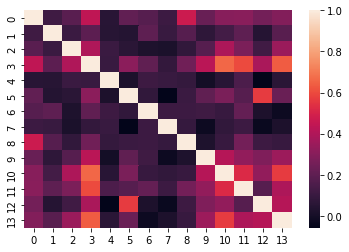

In [19]:
# Detect and remove outliers
for i in range(n_f):
  f = df.columns[i]
  quartile1 = X_t[f].quantile(0.25)
  quartile3 = X_t[f].quantile(0.75)
  iqr = abs(quartile3 - quartile1)
  upper_limit = quartile3 + 1.5 * iqr
  lower_limit = quartile1 - 1.5 * iqr
  I1 = X_t[f] <= upper_limit
  I2 = X_t[f] >= lower_limit
  I = np.logical_and(I1,I2)

X_trimmed = X_t[I]
y_trimmed = y_t[I]

#%% Feature selection
X = X_trimmed
y = y_trimmed

# Stage 1, removing features with low variance
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
threshold = 0.01
sel = VarianceThreshold(threshold = threshold).fit(X)
X_new = sel.transform(X)
f = df.columns
selected_features = sel.get_feature_names_out(input_features=None)
print("Number of selected features after variance threshold selection: ")
print(f"{X_new.shape[1]}\n")

# Stage 2, removing highly correlated features
r = np.corrcoef(X_new, y = None, rowvar = False)
columns = np.full((r.shape[0],), True, dtype=bool)
for i in range(r.shape[0]):
    for j in range(i+1, r.shape[0]):
        if abs(r[i,j]) >= 0.90:
            if columns[j]:
                columns[j] = False
X_new = X_new[:,columns]
selected_features = selected_features[columns]
print("Number of selected features after correlation analysis: ") 
print(f"{X_new.shape[1]}\n") 
                                 
# Stage 3, selecting features with high MI score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import  SelectPercentile
p = 10                        # Percentage of the number of features to keep
sel = SelectPercentile(mutual_info_classif, percentile = p).fit(X_new,y)
X_new = sel.transform(X_new)
f = df.columns
selected_features_indices = sel.get_support(indices = True)
selected_features = selected_features[selected_features_indices]
print("Number of selected features after SelectPercentile with MI metric: ")
print(f"{X_new.shape[1]}\n")
X = X_new
y = y_trimmed

# Inspecting final features
print("Selected features:\n")
print(f"{selected_features}")
r = np.corrcoef(X, y = None, rowvar = False)
sns.heatmap(r)

# Normalizing Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new = scaler.fit_transform(X)
print(np.mean(X, axis = 0))
print(np.var(X, axis = 0))
X = X_new

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.model_selection import StratifiedKFold

n_splits = 20
skf = StratifiedKFold(n_splits = n_splits)
folds = skf.split(X, y)

C = 0.3
clf = LinearSVC(random_state=0, tol=1e-5, C = C, 
                            fit_intercept = False, max_iter = 10000)
classifier = CalibratedClassifierCV(base_estimator = clf)

y_pred = dict()
y_test = dict()
y_score = dict()
ACC = dict()
PR = dict()
SN = dict()
SP = dict()
PRECISION = dict()
rr = np.linspace(0,1,100)
pr_re50 = np.zeros([n_splits,1])
i = -1;

for train_index, test_index in folds:
  i = i+1   
  X_train = X[train_index]
  X_test = X[test_index]
  Y = y.to_numpy()
  y_train = Y[train_index]
  y_test[i] = Y[test_index]
  y_pred[i] = classifier.fit(X_train, y_train).predict(X_test)
  dummy = classifier.predict_proba(X_test)  
  y_score[i] = dummy[:,1]
  tn, fp, fn, tp = confusion_matrix(y_test[i], y_pred[i]).ravel() 
  ACC[i] = (tp + tn)/(tp + tn + fp + fn)
  PR[i] = (tp)/(tp + fp)
  SN[i] = (tp)/(tp + fn)
  SP[i] = (tn)/(tn + fp) 
  precision, recall, _ = precision_recall_curve(y_test[i], y_score[i])
  PRECISION[i] = np.interp(rr, precision, recall)
  dummy = precision[recall>=0.5]
  pr_re50[i] = dummy[-1]
  dummy = recall[recall>=0.5]
  dummy = dummy[-1]
  print(f"Precision at recall = {np.round(dummy,2)}: {pr_re50[i]}")
  # disp = PrecisionRecallDisplay(precision=precision, recall=recall) 
  # disp.plot()
  print(i)


  

Precision at recall = 0.5: [0.30453564]
0


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
Y_test = y_test[0]
Y_pred = y_pred[0]
Y_score = y_score[0]
for i in range(n_splits - 1):
  Y_test = np.concatenate((Y_test, y_test[i+1]))
  Y_pred = np.concatenate((Y_pred, y_pred[i+1]))
  Y_score = np.concatenate((Y_score, y_score[i+1]))

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel() 
acc = (tp + tn)/(tp + tn + fp + fn)
pr = (tp)/(tp + fp)
sn = (tp)/(tp + fn)
sp = (tn)/(tn + fp)
print(f"Accuracy: {acc}")
print(f"Precision: {pr}")
print(f"Sensitivity: {sn}")
print(f"Specificity: {sp}")

plt.figure(1)
display = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
display.ax_.set_title('Overall Confusion Matrix With Selected Features')

from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
precision, recall, _ = precision_recall_curve(Y_test, Y_score)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()


fig, ax = plt.subplots()
for i in range(n_splits):
    ax.plot(PRECISION[i], rr, alpha=0.3, lw=1, label=f"Fold {i+1}") 

ax.plot(recall, precision, alpha=1, lw=1, label=f"Overall")

ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Overall Precision-Recall With Optimall Features')  
ax.legend(loc="upper right")
plt.show()

In [ ]:
dummy1 = np.array(pr_re50)
# print(dummy1)
mean_PR = np.mean(dummy1)
std_PR = np.std(dummy1)
print(f"Mean precision at recall 50: {mean_PR}")
print(f"Standard deviation for precision at recall 50: {std_PR}")

In [ ]:
rr = np.linspace(0,1,100)
print(X_eval.shape)
X_eval = scaler.transform(X_eval[selected_features])
y_pred_eval = classifier.fit(X, y).predict(X_eval)
dummy = classifier.predict_proba(X_eval)  
y_score_eval = dummy[:,1]
tn, fp, fn, tp = confusion_matrix(y_eval, y_pred_eval).ravel() 
ACC[i] = (tp + tn)/(tp + tn + fp + fn)
PR[i] = (tp)/(tp + fp)
SN[i] = (tp)/(tp + fn)
SP[i] = (tn)/(tn + fp) 
precision, recall, _ = precision_recall_curve(y_eval, y_score_eval)
PRECISION[i] = np.interp(rr, precision, recall)
dummy = precision[recall>=0.5]
pr_re50[i] = dummy[-1]
dummy = recall[recall>=0.5]
dummy = dummy[-1]
print(f"Precision at recall = {np.round(dummy,2)}: {pr_re50[i]}")


In [ ]:
fig, ax = plt.subplots()
ax.plot(recall, precision, alpha=1, lw=1,)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('PR Curve for Evaluation Data')  
ax.legend(loc="upper right")
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# Y_test = y_test[0]
# Y_pred = y_pred[0]
# # Y_score = y_score[0]
# for i in range(n_splits - 1):
#     Y_test = np.concatenate((Y_test, y_test[i+1]))
#     Y_pred = np.concatenate((Y_pred, y_pred[i+1]))
#     # Y_score = np.concatenate((Y_score, y_score[i+1]))

# tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel() 
# acc = (tp + tn)/(tp + tn + fp + fn)
# pr = (tp)/(tp + fp)
# sn = (tp)/(tp + fn)
# sp = (tn)/(tn + fp)
# print(f"Accuracy: {acc}")
# print(f"Precision: {pr}")
# print(f"Sensitivity: {sn}")
# print(f"Specificity: {sp}")

# plt.figure(1)
# display = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
# display.ax_.set_title('Overall Confusion Matrix With Selected Features')

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# X = X_new
# y = y_trimmed
# n_splits = 10
# skf = StratifiedKFold(n_splits = n_splits)
# folds = skf.split(X, y)

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.svm import LinearSVC
# from sklearn.tree import DecisionTreeClassifier
# # classifier = AdaBoostClassifier(base_estimator = 
# #                   DecisionTreeClassifier(), n_estimators=100, 
# #                   random_state=0, algorithm='SAMME')

# classifier = BaggingClassifier(base_estimator = 
#                   LinearSVC(C = 0.1, max_iter = 10000), n_estimators=20, 
#                   random_state=0)

# y_pred = dict()
# y_test = dict()
# y_score = dict()
# i = -1;
# for train_index, test_index in folds:
#   i = i+1   
#   X_train = X[train_index]
#   X_test = X[test_index]
#   Y = y.to_numpy()
#   y_train = Y[train_index]
#   y_test[i] = Y[test_index]
#   y_pred[i] = classifier.fit(X_train, y_train).predict(X_test)
#   # y_score[i] = classifier.score(X_test, y_test[i], sample_weight = None)
#   print(i)

# Y_test = y_test[0]
# Y_pred = y_pred[0]
# for i in range(n_splits - 1):
#     Y_test = np.concatenate((Y_test, y_test[i+1]))
#     Y_pred = np.concatenate((Y_pred, y_pred[i+1]))
#     # Y_score = np.concatenate((Y_score, y_score[i+1]))

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
# Y_test = y_test[0]
# Y_pred = y_pred[0]
# # Y_score = y_score[0]
# for i in range(n_splits - 1):
#     Y_test = np.concatenate((Y_test, y_test[i+1]))
#     Y_pred = np.concatenate((Y_pred, y_pred[i+1]))
#     # Y_score = np.concatenate((Y_score, y_score[i+1]))

# tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel() 
# acc = (tp + tn)/(tp + tn + fp + fn)
# pr = (tp)/(tp + fp)
# sn = (tp)/(tp + fn)
# sp = (tn)/(tn + fp)
# print(f"Accuracy: {acc}")
# print(f"Precision: {pr}")
# print(f"Sensitivity: {sn}")
# print(f"Specificity: {sp}")

# plt.figure(1)
# display = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
# display.ax_.set_title('Overall Confusion Matrix With Selected Features')